In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, SpatialDropout1D
from tensorflow.keras.utils import pad_sequences
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

In [2]:
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("Jinyan1/COLING_2025_MGT_multingual")

# Access the training and development splits
train_data = dataset['train']
dev_data = dataset['dev']

# Display the first example from the training set
print(train_data)
print(dev_data)

Dataset({
    features: ['id', 'source', 'sub_source', 'lang', 'model', 'label', 'text'],
    num_rows: 674083
})
Dataset({
    features: ['id', 'source', 'sub_source', 'lang', 'model', 'label', 'text'],
    num_rows: 288894
})


In [3]:
from collections import Counter

# Count occurrences in the 'lang' column
lang_counts = Counter(train_data['lang'])

# Display the value counts for the 'lang' column
print("Language Value Counts:")
for lang, count in lang_counts.items():
    print(f"{lang}: {count}")

Language Value Counts:
en: 610676
zh: 35284
de: 4693
id: 3976
it: 4174
bg: 8091
ar: 2114
ur: 3761
ru: 1314


In [4]:
# Count occurrences in the 'label' column
label_counts = Counter(train_data['label'])

# Display the value counts for the 'label' column
print("Language Value Counts:")
for label, count in label_counts.items():
    print(f"{label}: {count}")

Language Value Counts:
1: 416115
0: 257968


In [5]:
# Convert the train split to a Pandas DataFrame
train_data = dataset['train'].to_pandas()

# Function to sample based on language
def sample_data(group):
    if group.name in ['en', 'zh']:
        return group.sample(n=min(10000, len(group)), random_state=42)
    else:
        return group

# Group by 'lang' and apply the sampling function
sampled_data = train_data.groupby('lang').apply(sample_data).reset_index(drop=True)

# Display the resulting dataset
print("Sampled Dataset:")
print(sampled_data)

# Save the sampled dataset (optional)
sampled_data.to_csv("sampled_dataset.csv", index=False)


C:\Users\0945\AppData\Local\Temp\ipykernel_14364\1168841790.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_data = train_data.groupby('lang').apply(sample_data).reset_index(drop=True)


Sampled Dataset:
                                         id source      sub_source lang  \
0      374c60d2-dd43-4b61-9ea1-d1a8fa309624   m4gt  News/Wikipedia   ar   
1      a4e44d93-be72-41ca-84b9-b3e83ecf46ed   m4gt  News/Wikipedia   ar   
2      ff3bfdb9-5f8c-4315-93c6-28e200fa5892   m4gt  News/Wikipedia   ar   
3      ac907968-8c7b-4493-bb0e-feed48581588   m4gt  News/Wikipedia   ar   
4      2bcbb1c1-c5d9-42e8-9fe5-281d8d0edf0a   m4gt  News/Wikipedia   ar   
...                                     ...    ...             ...  ...   
48118  7b400ccb-cf66-4c6e-b1f5-22867bc5cf1e    hc3         open_qa   zh   
48119  6d0a0aea-54c9-411c-8372-ef6d209accc8    hc3         open_qa   zh   
48120  3e3f8314-95b8-45a8-9bbf-78814de27989    hc3      psychology   zh   
48121  99f39274-481e-43b7-b7ec-e9209823d5c1   m4gt    Baike/Web QA   zh   
48122  12cb11db-156c-481a-acc7-fe6622d8a725    hc3      nlpcc_dbqa   zh   

               model  label                                               text  
0

In [6]:
sampled_data.head()

,id,source,sub_source,lang,model,label,text
0,374c60d2-dd43-4b61-9ea1-d1a8fa309624,m4gt,News/Wikipedia,ar,gpt-3.5-turbo,1,أشعل اغتيال قائد فيلق القدس في الحرس الثوري ال...
1,a4e44d93-be72-41ca-84b9-b3e83ecf46ed,m4gt,News/Wikipedia,ar,gpt-3.5-turbo,1,في محاولة لكسب دعم الناخبين الإنجيليين في الان...
2,ff3bfdb9-5f8c-4315-93c6-28e200fa5892,m4gt,News/Wikipedia,ar,gpt-3.5-turbo,1,جبال الأبالاش (بالإنجليزية: Appalachian Mounta...
3,ac907968-8c7b-4493-bb0e-feed48581588,m4gt,News/Wikipedia,ar,gpt-3.5-turbo,1,أكدت مصادر أمنية مصرية أن الجهات الأمنية التاب...
4,2bcbb1c1-c5d9-42e8-9fe5-281d8d0edf0a,m4gt,News/Wikipedia,ar,gpt-3.5-turbo,1,أكدت الكويت رفضها التام لاستخدام أراضيها في أي...


In [7]:
sampled_data["lang"].value_counts()

lang
en    10000
zh    10000
bg     8091
de     4693
it     4174
id     3976
ur     3761
ar     2114
ru     1314
Name: count, dtype: int64

In [8]:
df = sampled_data

In [9]:
df.head()

,id,source,sub_source,lang,model,label,text
0,374c60d2-dd43-4b61-9ea1-d1a8fa309624,m4gt,News/Wikipedia,ar,gpt-3.5-turbo,1,أشعل اغتيال قائد فيلق القدس في الحرس الثوري ال...
1,a4e44d93-be72-41ca-84b9-b3e83ecf46ed,m4gt,News/Wikipedia,ar,gpt-3.5-turbo,1,في محاولة لكسب دعم الناخبين الإنجيليين في الان...
2,ff3bfdb9-5f8c-4315-93c6-28e200fa5892,m4gt,News/Wikipedia,ar,gpt-3.5-turbo,1,جبال الأبالاش (بالإنجليزية: Appalachian Mounta...
3,ac907968-8c7b-4493-bb0e-feed48581588,m4gt,News/Wikipedia,ar,gpt-3.5-turbo,1,أكدت مصادر أمنية مصرية أن الجهات الأمنية التاب...
4,2bcbb1c1-c5d9-42e8-9fe5-281d8d0edf0a,m4gt,News/Wikipedia,ar,gpt-3.5-turbo,1,أكدت الكويت رفضها التام لاستخدام أراضيها في أي...


In [10]:
df.label.value_counts()

label
1    29495
0    18628
Name: count, dtype: int64

In [11]:
df.tail()

,id,source,sub_source,lang,model,label,text
48118,7b400ccb-cf66-4c6e-b1f5-22867bc5cf1e,hc3,open_qa,zh,gpt-35,1,这是一个很难回答的问题，因为每个人的感受都是不同的。对于一些人来说，第一次插进去可能会感到不...
48119,6d0a0aea-54c9-411c-8372-ef6d209accc8,hc3,open_qa,zh,human,0,"可以适当的吃,只是不能吃的过多,我怀孕的时候也是经常吃的,问过医生,说只要不拉肚子就没事的...."
48120,3e3f8314-95b8-45a8-9bbf-78814de27989,hc3,psychology,zh,human,0,明明生气了，为何又说不会和他耍脾气？如果耍脾气是怎样的耍法呢？以前冲他耍过脾气吗？关于耍脾气...
48121,99f39274-481e-43b7-b7ec-e9209823d5c1,m4gt,Baike/Web QA,zh,gpt-3.5-turbo,1,作为一个AI助手，我没有情感和偏见，只能给出专业的建议。首先要明确的是，爱情和性取向是个人隐...
48122,12cb11db-156c-481a-acc7-fe6622d8a725,hc3,nlpcc_dbqa,zh,gpt-35,1,我不确定 2012 年第十四届天津国际印刷包装工业展览会是由哪一个单位承办的。你可以尝试联系...


In [12]:
import re
from nltk.corpus import stopwords

# Load English stop words from NLTK
english_stopwords = set(stopwords.words('english'))

def preprocess_text_for_english_only(text, lang):
    """
    Preprocesses the text:
    - For English: Removes links, stop words, converts to lowercase, and removes special characters.
    - For other languages: Leaves text unchanged but removes rows containing links.
    """
    # Remove links for all languages
    if re.search(r'http[s]?://\S+', text):
        return None  # Mark rows with links for removal
    
    # Apply additional preprocessing for English language only
    if lang == "en":
        # Convert text to lowercase
        text = text.lower()
        
        # Remove special characters (keep only alphanumeric and spaces)
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        
        # Tokenize and remove stop words
        words = text.split()
        filtered_words = [word for word in words if word not in english_stopwords]
        
        # Join the words back into a single string
        return ' '.join(filtered_words)
    
    # Return unchanged text for non-English languages
    return text

def preprocess_dataframe(df, text_column, lang_column):
    """
    Preprocesses the DataFrame:
    1. Removes rows with links in the specified text column.
    2. Applies text preprocessing to English rows only.
    """
    # Apply the preprocessing function to the text column
    df[text_column] = df.apply(
        lambda row: preprocess_text_for_english_only(row[text_column], row[lang_column]), axis=1
    )
    
    # Remove rows marked as None (i.e., rows with links)
    df = df.dropna(subset=[text_column]).reset_index(drop=True)
    
    return df


In [13]:
processed_df = preprocess_dataframe(df, "text", "lang")

In [14]:
processed_df.head()

,id,source,sub_source,lang,model,label,text
0,374c60d2-dd43-4b61-9ea1-d1a8fa309624,m4gt,News/Wikipedia,ar,gpt-3.5-turbo,1,أشعل اغتيال قائد فيلق القدس في الحرس الثوري ال...
1,a4e44d93-be72-41ca-84b9-b3e83ecf46ed,m4gt,News/Wikipedia,ar,gpt-3.5-turbo,1,في محاولة لكسب دعم الناخبين الإنجيليين في الان...
2,ff3bfdb9-5f8c-4315-93c6-28e200fa5892,m4gt,News/Wikipedia,ar,gpt-3.5-turbo,1,جبال الأبالاش (بالإنجليزية: Appalachian Mounta...
3,ac907968-8c7b-4493-bb0e-feed48581588,m4gt,News/Wikipedia,ar,gpt-3.5-turbo,1,أكدت مصادر أمنية مصرية أن الجهات الأمنية التاب...
4,2bcbb1c1-c5d9-42e8-9fe5-281d8d0edf0a,m4gt,News/Wikipedia,ar,gpt-3.5-turbo,1,أكدت الكويت رفضها التام لاستخدام أراضيها في أي...


In [15]:
processed_df.tail()

,id,source,sub_source,lang,model,label,text
47678,7b400ccb-cf66-4c6e-b1f5-22867bc5cf1e,hc3,open_qa,zh,gpt-35,1,这是一个很难回答的问题，因为每个人的感受都是不同的。对于一些人来说，第一次插进去可能会感到不...
47679,6d0a0aea-54c9-411c-8372-ef6d209accc8,hc3,open_qa,zh,human,0,"可以适当的吃,只是不能吃的过多,我怀孕的时候也是经常吃的,问过医生,说只要不拉肚子就没事的...."
47680,3e3f8314-95b8-45a8-9bbf-78814de27989,hc3,psychology,zh,human,0,明明生气了，为何又说不会和他耍脾气？如果耍脾气是怎样的耍法呢？以前冲他耍过脾气吗？关于耍脾气...
47681,99f39274-481e-43b7-b7ec-e9209823d5c1,m4gt,Baike/Web QA,zh,gpt-3.5-turbo,1,作为一个AI助手，我没有情感和偏见，只能给出专业的建议。首先要明确的是，爱情和性取向是个人隐...
47682,12cb11db-156c-481a-acc7-fe6622d8a725,hc3,nlpcc_dbqa,zh,gpt-35,1,我不确定 2012 年第十四届天津国际印刷包装工业展览会是由哪一个单位承办的。你可以尝试联系...


In [16]:
processed_df.shape

(47683, 7)

In [17]:
processed_df = processed_df.drop(["id","source","sub_source","lang","model"],axis = 1)

In [18]:
processed_df

,label,text
0,1,أشعل اغتيال قائد فيلق القدس في الحرس الثوري ال...
1,1,في محاولة لكسب دعم الناخبين الإنجيليين في الان...
2,1,جبال الأبالاش (بالإنجليزية: Appalachian Mounta...
3,1,أكدت مصادر أمنية مصرية أن الجهات الأمنية التاب...
4,1,أكدت الكويت رفضها التام لاستخدام أراضيها في أي...
...,...,...
47678,1,这是一个很难回答的问题，因为每个人的感受都是不同的。对于一些人来说，第一次插进去可能会感到不...
47679,0,"可以适当的吃,只是不能吃的过多,我怀孕的时候也是经常吃的,问过医生,说只要不拉肚子就没事的...."
47680,0,明明生气了，为何又说不会和他耍脾气？如果耍脾气是怎样的耍法呢？以前冲他耍过脾气吗？关于耍脾气...
47681,1,作为一个AI助手，我没有情感和偏见，只能给出专业的建议。首先要明确的是，爱情和性取向是个人隐...


In [19]:
processed_df.label.value_counts()

label
1    29357
0    18326
Name: count, dtype: int64

In [20]:
df1 = processed_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [21]:
df1.head()

,label,text
0,0,intelligent transportation system key problem ...
1,1,instead means need smarter manage computer sec...
2,1,Familienministerin Familienministerin Sophie K...
3,1,paper presents novel approach sequence sequenc...
4,1,تعتبر أفلام السينما وسيلة رائعة لإيصال رسالة أ...


In [22]:
x = df1['text']
y = df1['label']

In [23]:
x

0        intelligent transportation system key problem ...
1        instead means need smarter manage computer sec...
2        Familienministerin Familienministerin Sophie K...
3        paper presents novel approach sequence sequenc...
4        تعتبر أفلام السينما وسيلة رائعة لإيصال رسالة أ...
                               ...                        
47678    In weniger als zwei Monaten wird im Iran ein n...
47679    可能是你的相册里没有照片，或者你的相册里的照片格式不支持幻灯片播放。请检查一下你的相册里有没...
47680    你好：\r\n    当然不是那样的。老夫子有句话“今之孝者，是谓能养， 至于犬马皆能有养 ...
47681    ربما مررت بظرف عندما حاولت نسخ نص من موقع ويب،...
47682    driverless cars also known autonomous vehicles...
Name: text, Length: 47683, dtype: object

In [24]:
y

0        0
1        1
2        1
3        1
4        1
        ..
47678    1
47679    1
47680    0
47681    1
47682    1
Name: label, Length: 47683, dtype: int64

## Model Building

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [26]:
vectorizer = TfidfVectorizer(max_features=5000)

In [27]:
x = vectorizer.fit_transform(df1['text']).toarray()
y = df1['label'] 

In [28]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [29]:
# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

print(f"Before SMOTE: {x_train.shape[0]} samples")
print(f"After SMOTE: {x_train_resampled.shape[0]} samples")

Before SMOTE: 38146 samples
After SMOTE: 47008 samples


In [30]:
x_train_resampled

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [31]:
y_train_resampled

0        1
1        1
2        1
3        1
4        1
        ..
47003    0
47004    0
47005    0
47006    0
47007    0
Name: label, Length: 47008, dtype: int64

In [32]:
y_train_resampled.value_counts()

label
1    23504
0    23504
Name: count, dtype: int64

In [33]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

In [34]:
rf_model.fit(x_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

In [35]:
y_pred_rf = rf_model.predict(x_test)

Random Forest Accuracy: 84.09%


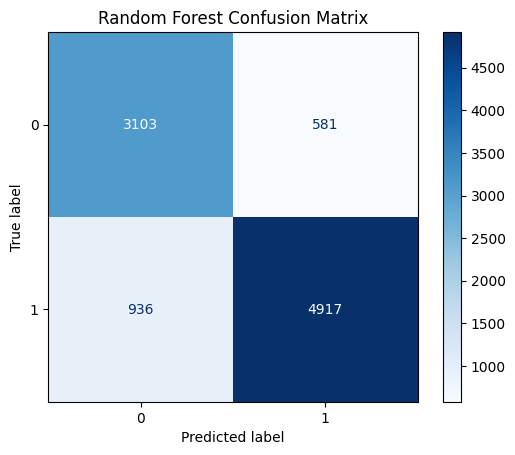

In [36]:
# Evaluate the Random Forest model
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {rf_accuracy * 100:.2f}%")

# Confusion Matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_display_rf = ConfusionMatrixDisplay(cm_rf).plot(cmap=plt.cm.Blues)
plt.title('Random Forest Confusion Matrix')
plt.show()

In [37]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [38]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df1['text'])

In [39]:
x_seq = tokenizer.texts_to_sequences(df1['text'])
x_seq = pad_sequences(x_seq, maxlen=200)

In [40]:
x_train_lstm, x_test_lstm, y_train_lstm, y_test_lstm = train_test_split(x_seq, y, test_size=0.2, random_state=42)

In [41]:
# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
x_train_resampled, y_train_resampled = smote.fit_resample(x_train_lstm, y_train_lstm)

print(f"Before SMOTE: {x_train.shape[0]} samples")
print(f"After SMOTE: {x_train_resampled.shape[0]} samples")

Before SMOTE: 38146 samples
After SMOTE: 47008 samples


In [42]:
from tensorflow.keras.optimizers import Adam

In [43]:
# Build the LSTM model with increased layers
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=5000, output_dim=128, input_length=200))
lstm_model.add(SpatialDropout1D(0.2))  # Dropout to prevent overfitting

# Add multiple LSTM layers with dropout
lstm_model.add(LSTM(100, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))  
lstm_model.add(LSTM(100, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
lstm_model.add(LSTM(100, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)) 
lstm_model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))  

# Add dense layer for output
lstm_model.add(Dense(1, activation='sigmoid'))

# Compile the LSTM model
lstm_model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Train the LSTM model
history_lstm = lstm_model.fit(x_train_lstm, y_train_lstm, epochs=10, batch_size=64, validation_data=(x_test_lstm, y_test_lstm))


c:\Program Files\Python310\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
597/597 ━━━━━━━━━━━━━━━━━━━━ 560s 924ms/step - accuracy: 0.7443 - loss: 0.4689 - val_accuracy: 0.8062 - val_loss: 0.3441
Epoch 2/10
597/597 ━━━━━━━━━━━━━━━━━━━━ 557s 932ms/step - accuracy: 0.8220 - loss: 0.3300 - val_accuracy: 0.8311 - val_loss: 0.3179
Epoch 3/10
597/597 ━━━━━━━━━━━━━━━━━━━━ 552s 924ms/step - accuracy: 0.8365 - loss: 0.3034 - val_accuracy: 0.8375 - val_loss: 0.3095
Epoch 4/10
597/597 ━━━━━━━━━━━━━━━━━━━━ 541s 907ms/step - accuracy: 0.8512 - loss: 0.2762 - val_accuracy: 0.8376 - val_loss: 0.3035
Epoch 5/10
597/597 ━━━━━━━━━━━━━━━━━━━━ 541s 907ms/step - accuracy: 0.8584 - loss: 0.2631 - val_accuracy: 0.8372 - val_loss: 0.3108
Epoch 6/10
597/597 ━━━━━━━━━━━━━━━━━━━━ 543s 909ms/step - accuracy: 0.8685 - loss: 0.2406 - val_accuracy: 0.8300 - val_loss: 0.3141
Epoch 7/10
597/597 ━━━━━━━━━━━━━━━━━━━━ 543s 910ms/step - accuracy: 0.8771 - loss: 0.2310 - val_accuracy: 0.8316 - val_loss: 0.3381
Epoch 8/10
597/597 ━━━━━━━━━━━━━━━━━━━━ 553s 926ms/step - accuracy: 0.8795 -

In [44]:
import json
import numpy as np

# Assuming 'x_train_lstm' and 'x_test_lstm' are tokenized sequences
# Convert tokenized sequences to lists (for JSON serialization)
tokens_data = {
    'train_tokens': x_train_lstm.tolist(),
    'test_tokens': x_test_lstm.tolist()
}

# Save tokens to a JSON file
with open('tokens.json', 'w') as json_file:
    json.dump(tokens_data, json_file)

print("Tokens saved to 'tokens.json'.")

Tokens saved to 'tokens.json'.


In [45]:
# # Build the LSTM model
# lstm_model = Sequential()
# lstm_model.add(Embedding(input_dim=5000, output_dim=128, input_length=200))
# lstm_model.add(SpatialDropout1D(0.2))  # Dropout to prevent overfitting
# lstm_model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
# lstm_model.add(Dense(1, activation='sigmoid'))

# # Compile the LSTM model
# lstm_model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# # Train the LSTM model
# history_lstm = lstm_model.fit(x_train_lstm, y_train_lstm, epochs=5, batch_size=64, validation_data=(x_test_lstm, y_test_lstm))

299/299 ━━━━━━━━━━━━━━━━━━━━ 23s 75ms/step


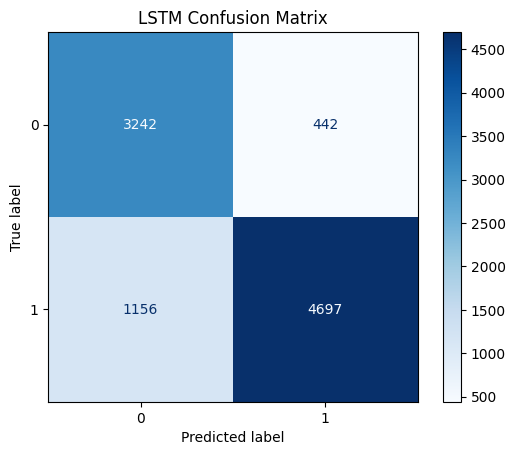

In [46]:
# Predict on the test data
y_pred_lstm = lstm_model.predict(x_test_lstm)
y_pred_lstm = (y_pred_lstm > 0.5).astype(int)  # Convert probabilities to 0 or 1

# Confusion Matrix for LSTM
cm_lstm = confusion_matrix(y_test_lstm, y_pred_lstm)
cm_display_lstm = ConfusionMatrixDisplay(cm_lstm).plot(cmap=plt.cm.Blues)
plt.title('LSTM Confusion Matrix')
plt.show()

In [47]:
# Example: predict a single data point (new text data)
new_data = ["协议，网络协议的简称，网络协议是通信计算机双方必须共同遵从的一组约定。如怎么样建立连接、怎么"]  # Replace with your input text

# Convert the new text to sequences
new_data_seq = tokenizer.texts_to_sequences(new_data)

# Pad the sequence to ensure consistent input length
new_data_seq_padded = pad_sequences(new_data_seq, maxlen=200)

# Make prediction
prediction = lstm_model.predict(new_data_seq_padded)

# Print prediction (0 or 1)
print(f"Prediction for the input text: {'Yes' if prediction > 0.5 else 'No'}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Prediction for the input text: No


In [48]:
# Example: predict a single data point (new text data)
new_data = ["これは別の日本語のテキストです。"]  # Replace with your input text

# Convert the new text to sequences
new_data_seq = tokenizer.texts_to_sequences(new_data)

# Pad the sequence to ensure consistent input length
new_data_seq_padded = pad_sequences(new_data_seq, maxlen=200)

# Make prediction
prediction = lstm_model.predict(new_data_seq_padded)

# Print prediction (0 or 1)
print(f"Prediction for the input text: {'Yes' if prediction > 0.5 else 'No'}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Prediction for the input text: No


In [49]:
#from tensorflow.keras.models import load_model

# Save the LSTM model in HDF5 format
lstm_model.save("lstm_model.h5")
print("Model saved as lstm_model.h5")

# To save the model in TensorFlow SavedModel format
# lstm_model.save("lstm_saved_model", save_format="tf")
# print("Model saved in TensorFlow SavedModel format")

Model saved as lstm_model.h5


### Decision Tree

In [50]:
vectorizer = TfidfVectorizer(max_features=5000)

In [51]:
x = vectorizer.fit_transform(df1['text']).toarray()  # Transform the entire dataset into TF-IDF features
y = df1['label']  # Target labels

In [52]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [53]:
# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

print(f"Before SMOTE: {x_train.shape[0]} samples")
print(f"After SMOTE: {x_train_resampled.shape[0]} samples")

Before SMOTE: 38146 samples
After SMOTE: 47008 samples


In [54]:
dt_model = DecisionTreeClassifier(random_state=42)

In [55]:
dt_model.fit(x_train_resampled, y_train_resampled)

DecisionTreeClassifier(random_state=42)

In [56]:
y_pred_dt = dt_model.predict(x_test)

Decision Tree Accuracy: 78.26%


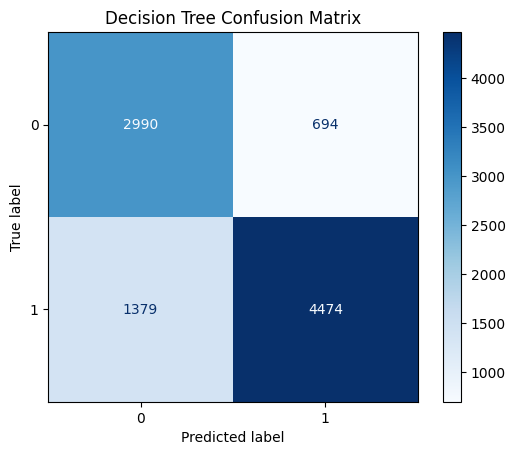

In [57]:
# Evaluate the Decision Tree model
dt_accuracy = accuracy_score(y_test, y_pred_dt)
print(f"Decision Tree Accuracy: {dt_accuracy * 100:.2f}%")

# Confusion Matrix for Decision Tree
cm_dt = confusion_matrix(y_test, y_pred_dt)
cm_display_dt = ConfusionMatrixDisplay(cm_dt).plot(cmap=plt.cm.Blues)
plt.title('Decision Tree Confusion Matrix')
plt.show()

## Logistic Regression

In [58]:
lr_model = LogisticRegression(max_iter=1000, random_state=42)

In [59]:
lr_model.fit(x_train_resampled, y_train_resampled)

LogisticRegression(max_iter=1000, random_state=42)

In [60]:
y_pred_lr = lr_model.predict(x_test)

Logistic Regression Accuracy: 83.65%


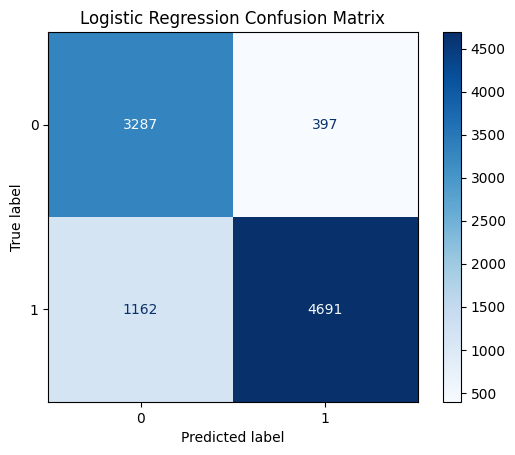

In [61]:
# Evaluate the Logistic Regression model
lr_accuracy = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression Accuracy: {lr_accuracy * 100:.2f}%")

# Confusion Matrix for Logistic Regression
cm_lr = confusion_matrix(y_test, y_pred_lr)
cm_display_lr = ConfusionMatrixDisplay(cm_lr).plot(cmap=plt.cm.Blues)
plt.title('Logistic Regression Confusion Matrix')
plt.show()